In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer
from typing import List, Tuple, Dict

EPSILON = 1e-16

# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


## Przydatne funkcje


In [2]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]
polygon_example_colors = [1, 3, 1, 0, 2, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 2, 0, 4]
polygon_example_tri = [(polygon_example_1[0], polygon_example_1[2]),
                      (polygon_example_1[2], polygon_example_1[5]),
                      (polygon_example_1[2], polygon_example_1[6]),
                      (polygon_example_1[2], polygon_example_1[4])]

def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    vis.show()

def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

def draw_polygon_tri(polygon,tri):

    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

def orient(a, b, c):
    return  a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - c[0] * b[1] - a[1] * b[0] - a[0] * c[1]

def load_polygon_from_file(file_path: str) -> List[Tuple[float, float]]:
    with open(file_path, 'r') as f:
        points = []
        for line in f:
            x, y = map(float, line.strip().split())
            points.append((x, y))
    return points

def save_polygon_to_file(polygon: List[Tuple[float, float]], file_path: str):
    with open(file_path, 'w') as f:
        for point in polygon:
            f.write(f"{point[0]} {point[1]}\n")

def save_triangulation_to_file(triangulation: List[Tuple[int, int]], file_path: str):
    with open(file_path, 'w') as f:
        for edge in triangulation:
            f.write(f"{edge[0]} {edge[1]}\n")

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

In [148]:
draw_polygon(polygon_example_1)

## Wprowadzanie wielokąta za pomocą myszki

Aby stworzyć własny wielokąt, zaznacz jego kolejne wierzchołki dwukrotnym kliknięciem lewego przycisku myszy. Punkty należy wprowadzać w kierunku przeciwnym do ruchu wskazówek zegara. Po wprowadzeniu co najmniej trzech wierzchołków, zakończ rysowanie poprzez dwukrotne kliknięcie prawym przyciskiem myszy.

In [33]:
%matplotlib tk

polygon = []

events = []
active = True
tmp_line = None

def draw_point(point):
    """
    Umieszcza punkt o danych współrzędnych na płaszczyźnie.
    :param point: krotka (x, y) określająca położenie punktu
    """
    plt.scatter(point[0], point[1], color="red")
    plt.show()

def draw_line(points, style='solid', color='red', linewidth=1.0, alpha=1.0):
    """
    Tworzy linię łączącą dwa punkty na płaszczyźnie.
    :param points: lista krotek reprezentujących punkty, pomiędzy którymi dodajemy krawędź
    """
    ax = plt.gca()
    x = [points[0][0], points[1][0]]
    y = [points[0][1], points[1][1]]
    line, = ax.plot(x, y, linestyle = style, color = color, linewidth = linewidth, alpha = alpha)
    ax.figure.canvas.draw()
    return line

def onclick(event):
    """
    Obsługuje interakcję z myszą:
    - podwójne kliknięcie lewym przyciskiem dodaje nowy punkt
    - podwójne kliknięcie prawym przyciskiem kończy tworzenie wielokąta
    :param event: obiekt zawierający dane o zdarzeniu myszy
    """
    global active, tmp_line
    if event.dblclick and active:
        if event.button == 1:
            x = event.xdata
            y = event.ydata
            polygon.append((x, y))
            events.append(event)
            draw_point((x, y))
            if len(polygon) > 1:
                draw_line([polygon[-2], polygon[-1]])
            if len(polygon) >= 3:
                if tmp_line is not None:
                    tmp_line.remove()
                tmp_line = draw_line([polygon[-1], polygon[0]],style = 'dashed', color = 'gray', linewidth = 1.0, alpha = 0.5)
        elif event.button == 3 and len(polygon) > 2:
            if tmp_line is not None:
                tmp_line.remove()
                tmp_line = None
            draw_line([polygon[-1], polygon[0]])
            active = False
            plt.pause(0.5)
            ax.set_title("Wielokąt został utworzony. Zamykanie okna...")
            plt.pause(2)
            plt.close()

fig, ax = plt.subplots()
plt.get_current_fig_manager().set_window_title("Kreator wielokąta")
ax.set_title("Podwójne kliknięcie LPM: dodaj punkt\nPodwójne kliknięcie PPM: zakończ")
connection_id = fig.canvas.mpl_connect("button_press_event", onclick)
ax.set_xlim([0, 2])
ax.set_ylim([0, 2])
# ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.ion()
plt.show()

Lub wczytaj go z pliku.

In [11]:
polygon = load_polygon_from_file("polygon_input.txt")

Sprawdź wizualizację swojego wielokątu.

[(np.float64(0.6306849267601572), np.float64(0.1747331617836937)), (np.float64(1.7601835648522919), np.float64(0.5032489963634152)), (np.float64(1.0256482031932277), np.float64(0.8422493788552556)), (np.float64(1.7674085028358237), np.float64(1.104363076658225)), (np.float64(0.813716689009629), np.float64(1.191734309259215)), (np.float64(1.8083498180758368), np.float64(1.5027758973187386)), (np.float64(0.6812594926448797), np.float64(1.5551986368793325)), (np.float64(1.7650001901746464), np.float64(1.8347865812025)), (np.float64(0.3103793428235817), np.float64(1.7963432388580642))]


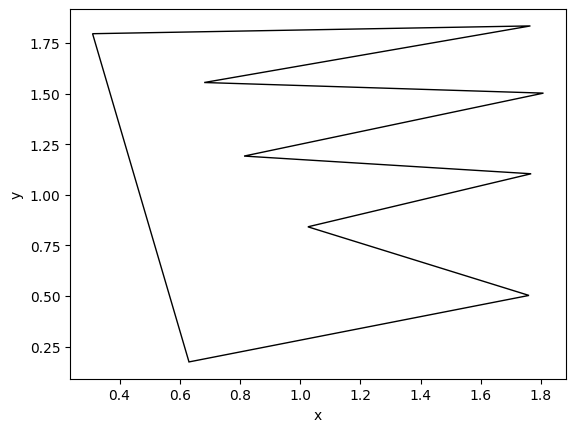

In [35]:
%matplotlib inline

if len(polygon) < 2: print("Liczba punktów mniejsza niż 3")
else:
    draw_polygon(polygon)
    print(polygon)

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [24]:
def is_y_monotonic(polygon: List[Tuple[float, float]]) -> bool:
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    min_ind = 0
    min_y = polygon[0][1]
    for k in range(len(polygon)):
        if polygon[k][1] < min_y:
            min_y = polygon[k][1]
            min_ind = k

    i = min_ind
    j = min_ind
    n = len(polygon)

    switched_x = False
    switched_y = False
    while True:
        if cmp_switch(polygon[i % n][1], polygon[(i + 1) % n][1], switched_x):
            if switched_x or switched_y:
                return False
            switched_x = True
        i += 1
        i %= n

        if cmp_switch(polygon[j % n][1], polygon[(j - 1) % n][1], switched_y):
            if switched_x or switched_y:
                return False
            switched_y = True
        j -= 1
        j %= n

        if j == (min_ind + n // 2 ) % n:
            break

    return True

def cmp_switch(a, b, switch):
    if switch:
        return a < b
    else:
        return a > b

Przeprowadź test poprawności powyższej funkcji.

In [145]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.001s


Sprawdź monotoniczność swojego wielokątu.

In [25]:
print(is_y_monotonic(polygon))

True


***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których zaczyna się monotoniczny spadek
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji.
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny.
- prawidłowy, pozostałe przypadki, jeden sąsiad powyżej, drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

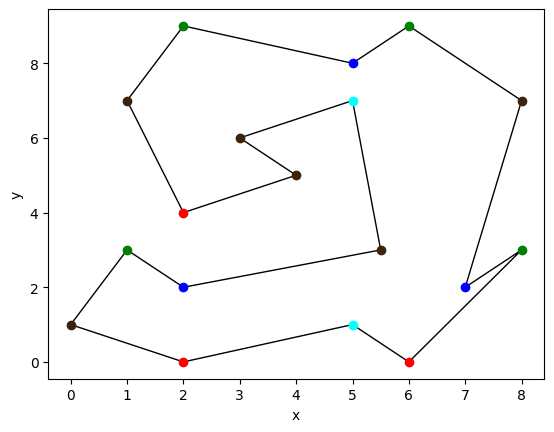

In [46]:
draw_polygon_colors(polygon_example_2,polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [20]:
def color_vertex(polygon):
    """
    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """
    n = len(polygon)
    colors = [None for _ in range(n)]

    for i in range(n):
        prev = polygon[i - 1]
        curr = polygon[i]
        next = polygon[(i + 1) % n]
        if prev[1] < curr[1] and next[1] < curr[1]:
            o = orient(prev, curr, next)
            if o > EPSILON:
                colors[i] = 0
            elif o < -EPSILON:
                colors[i] = 3
            else: colors[i] = 4
        elif prev[1] > curr[1] and next[1] > curr[1]:
            o = orient(prev, curr, next)
            if o > EPSILON:
                colors[i] = 1
            elif o < -EPSILON:
                colors[i] = 2
            else: colors[i] = 4
        else:
            colors[i] = 4

    return colors

Przeprowadź test poprawności powyższej funkcji. 

In [26]:
Test().runtest(2, color_vertex)

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.004s


Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

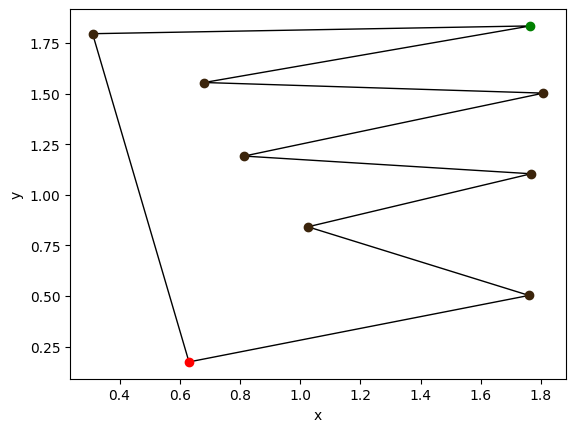

In [36]:
colors = color_vertex(polygon)
draw_polygon_colors(polygon,colors)

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

### Przykładowy wielokąt podzielony na trójkąty.

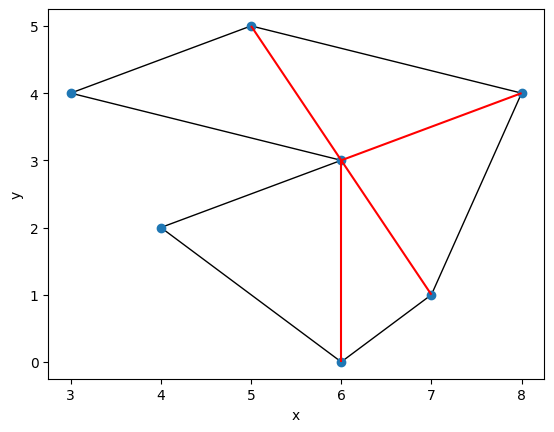

In [50]:
draw_polygon_tri(polygon_example_1, polygon_example_tri)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [5]:
def merged_chains(polygon) -> List[Tuple[Tuple[float, float], str]]:
    min_ind = 0
    min_y = polygon[0][1]
    max_ind = 0
    max_y = polygon[0][1]
    for k in range(len(polygon)):
        if polygon[k][1] < min_y:
            min_y = polygon[k][1]
            min_ind = k
        if polygon[k][1] > max_y:
            max_y = polygon[k][1]
            max_ind = k

    merged = [None for _ in range(len(polygon))]
    
    n = len(polygon)
    i = min_ind
    j = min_ind
    k = 0
    while j != max_ind and i != max_ind:
        if polygon[j][1] < polygon[i][1]:
            merged[k] = (polygon[j], 'l')
            j -= 1
            j %= n
        else:
            merged[k] = (polygon[i], 'r')
            i += 1
            i %= n
        k+=1
    while i != max_ind:
        merged[k] = (polygon[i], 'r')
        i += 1
        i %= n
        k+=1
    while j != max_ind:
        merged[k] = (polygon[j], 'l')
        j -= 1
        j %= n
        k+=1
    merged.append((polygon[max_ind], 'r'))
    return merged


In [6]:
def triangulation_diag_only(polygon: List[Tuple[float, float]] ) -> List[Tuple[int, int]]:
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki o indeksach 1 i 5 oraz 2 i 3
    """
    #draw_polygon(polygon) #odkomentować aby zobaczyć wielokąt wejściowy
    polygon_dict: Dict[Tuple[float, float], int] = {k: v for v, k in enumerate(polygon)}
    triangulation: List[Tuple[int, int]] = []
    merged = merged_chains(polygon)
    stack: List[Tuple[Tuple[float, float], str]] = [merged[0], merged[1]]

    for k in range(2, len(merged)):
        current = merged[k]
        if current[1] != stack[-1][1]:
            for s in stack:
                diff = abs(polygon_dict[current[0]] - polygon_dict[s[0]])
                if diff > 1 and diff < len(polygon) - 1:
                    triangulation.append((polygon_dict[current[0]], polygon_dict[s[0]]))
            stack = [stack[-1]]
        else:
            top = len(stack) - 1
            for j in range(len(stack) - 2, -1, -1):
                thrd = stack[j]
                o = orient(current[0], stack[top][0], thrd[0])
                if (current[1] == 'l' and o > EPSILON) or (current[1] == 'r' and o < -EPSILON):
                    diff = abs(polygon_dict[current[0]] - polygon_dict[thrd[0]])
                    if diff > 1 and diff < len(polygon) - 1:
                        triangulation.append((polygon_dict[current[0]], polygon_dict[thrd[0]]))
                    for _ in range(len(stack) - 1, top - 1, -1):
                        stack.pop()
                    top = j
        stack.append(current)
    #draw_polygon_tri(polygon, [(polygon[x], polygon[y]) for (x, y) in triangulation]) #odkomentować aby zobaczyć triangulację
    return triangulation #+ [(i, (i + 1) % len(polygon)) for i in range(len(polygon))]

In [7]:
def triangulation(polygon: List[Tuple[float, float]] ) -> List[Tuple[int, int]]:
    return triangulation_diag_only(polygon) + [(i, (i + 1) % len(polygon)) for i in range(len(polygon))]

Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ: 
Do przechowywania wielokątu użyta jest lista krotek jego współrzędnych, sąsiadujące punkty w liście są połączone bokami oraz pierwszy element z ostatnim. Jest to efektywny pamięciowo i wygodny sposób trzymania danych wielokątu.
Do tego aby łatwo znaleźć indeks punktu została utworzona mapa o kluczu jako krotce współrzędnych i indeksie jako wartości.

Dla utworzonej triangulacji zwracana jest lista par indeksów punktów wielokąta oznaczającą te przekątne, które tworzą tą triangulację.

Przeprowadź testy poprawności powyższej funkcji.


In [44]:
Test().runtest(3, triangulation_diag_only)

Lab 3, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: WRONG ANSWER
		Output:   [(8, 10), (7, 10), (11, 7), (6, 11), (12, 6), (5, 12), (13, 5), (4, 13), (14, 4), (3, 14), (15, 3), (2, 15), (16, 2), (1, 16), (17, 1)]
		Expected: [[1, 17], [16, 1], [16, 2], [2, 15], [3, 15], [3, 14], [4, 14], [13, 4], [5, 13], [12, 5], [6, 12], [11, 6], [7, 11], [8, 11], [10, 8]]
	Test 4: WRONG ANSWER
		Output:   [(0, 8), (7, 0), (1, 7), (2, 7), (6, 2), (3, 6), (4, 6)]
		Expected: [[3, 5], [3, 6], [2, 6], [1, 6], [7, 1], [0, 7], [8, 0]]
	Test 5: Passed
	Test 6: WRONG ANSWER
		Output:   [(1, 8), (3, 1), (3, 8), (5, 3), (5, 8), (7, 5)]
		Expected: [[5, 7], [3, 5], [3, 7], [1, 3], [1, 7], [8, 1]]
	Test 7: WRONG ANSWER
		Output:   [(9, 11), (7, 9), (7, 11), (5, 7), (5, 11), (0, 5), (4, 0), (3, 0), (1, 3)]
		Expected: [[3, 1], [0, 4], [0, 3], [5, 0], [0, 6], [7, 0], [9, 7], [0, 9], [11, 9]]
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 6/10
Time: 1.189s


Funkcja nie przechodzi poprawnie wszystkich powyższych testów, ponieważ na ogół istnieje więcej niż jedna triangulacja danego wielokąta. Można odkomentować linię rysujące wielokąt wejściowy oraz jego triangulację w funkcji `triangulate_diag_only` aby to zweryfikować.

Zwizualizuj powstały wielokąt podzielony na trójkąty.

[(2, 0), (4, 2), (4, 0), (6, 4), (6, 0), (8, 6), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 0)]


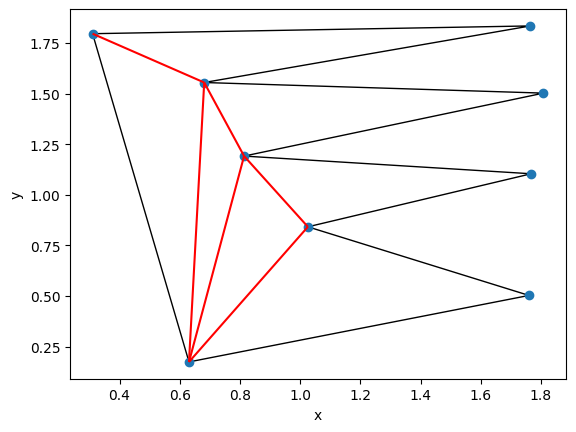

In [38]:
tri_diag = triangulation_diag_only(polygon)
tri = triangulation(polygon)
print(tri)
draw_polygon_tri(polygon, [(polygon[x], polygon[y]) for (x, y) in tri_diag])

Zapisz swój wielokąt oraz jego triangulację do pliku.

In [40]:
save_polygon_to_file(polygon, "polygon_output.txt")
save_triangulation_to_file(tri, "triangulation_output.txt")

## Animacja procesu triangulacji

In [37]:

def triangulation_vis(polygon: List[Tuple[float, float]] ) -> Visualizer:
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki o indeksach 1 i 5 oraz 2 i 3
    """
    #draw_polygon(polygon) #odkomentować aby zobaczyć wielokąt wejściowy
    polygon_dict: Dict[Tuple[float, float], int] = {k: v for v, k in enumerate(polygon)}
    triangulation: List[Tuple[int, int]] = []
    merged = merged_chains(polygon)
    stack: List[Tuple[Tuple[float, float], str]] = [merged[0], merged[1]]

    vis = Visualizer()
    vis.add_line_segment([(polygon[i], polygon[(i + 1) % len(polygon)]) for i in range(len(polygon))], color = "black")
    vis.add_point([stack[0][0], stack[1][0]], color = "red")

    for k in range(2, len(merged)):
        current = merged[k]
        vis.add_point(current[0], color = "red")
        if current[1] != stack[-1][1]:
            for s in stack:
                diff = abs(polygon_dict[current[0]] - polygon_dict[s[0]])
                if diff > 1 and diff < len(polygon) - 1:
                    triangulation.append((polygon_dict[current[0]], polygon_dict[s[0]]))
                    vis.add_line_segment((current[0], s[0]), color="red")
            stack = [stack[-1]]
        else:
            top = len(stack) - 1
            for j in range(len(stack) - 2, -1, -1):
                thrd = stack[j]
                o = orient(current[0], stack[top][0], thrd[0])
                if (current[1] == 'l' and o > EPSILON) or (current[1] == 'r' and o < -EPSILON):
                    diff = abs(polygon_dict[current[0]] - polygon_dict[thrd[0]])
                    if diff > 1 and diff < len(polygon) - 1:
                        triangulation.append((polygon_dict[current[0]], polygon_dict[thrd[0]]))
                        vis.add_line_segment((current[0], thrd[0]), color = "red")
                    for _ in range(len(stack) - 1, top - 1, -1):
                        stack.pop()
                    top = j
        stack.append(current)
    #draw_polygon_tri(polygon, [(polygon[x], polygon[y]) for (x, y) in triangulation]) #odkomentować aby zobaczyć triangulację
    return vis

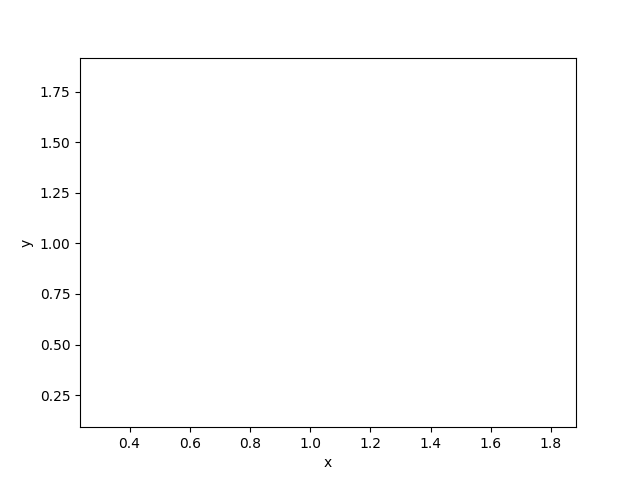

In [39]:
tri_vis = triangulation_vis(polygon)
tri_vis.show_gif()